In [4]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [5]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

In [15]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777701 entries, 0 to 2777700
Data columns (total 15 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ticker           string        
 1   Date             datetime64[ns]
 2   Open             float64       
 3   High             float64       
 4   Low              float64       
 5   Close            float64       
 6   Adj Close        float64       
 7   Volume           int64         
 8   sector           string        
 9   subsector        string        
 10  year             int32         
 11  Close_lag_1      float64       
 12  returns          float64       
 13  positive_return  int64         
 14  target           float64       
dtypes: datetime64[ns](1), float64(8), int32(1), int64(2), string(3)
memory usage: 315.6 MB


# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [7]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
1043459,EXC,2002-03-26,18.937233,18.969330,18.455776,18.580599,8.049511,2620899,Utilities,Electric Utilities,2002,18.937233,-0.018832,0,1.0
1250052,TPR,2006-07-06,28.770000,29.320000,28.500000,29.260000,19.345259,2818900,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",2006,28.790001,0.016325,1,0.0
2259567,CPRT,2019-11-06,20.620001,20.620001,20.177500,20.465000,20.465000,4983200,Industrials,Diversified Support Services,2019,20.562500,-0.004742,0,0.0
1246509,EXPE,2016-06-17,104.080002,104.720001,103.070000,104.139999,100.174484,2697800,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",2016,104.349998,-0.002012,0,1.0
721062,GPC,2023-11-01,128.830002,129.199997,127.650002,128.779999,125.226578,1051200,Consumer Discretionary,Distributors,2023,128.860001,-0.000621,0,1.0


In [8]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [9]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)
simple_sample_dt.shape, small_df.shape

((5506, 15), (55055, 15))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

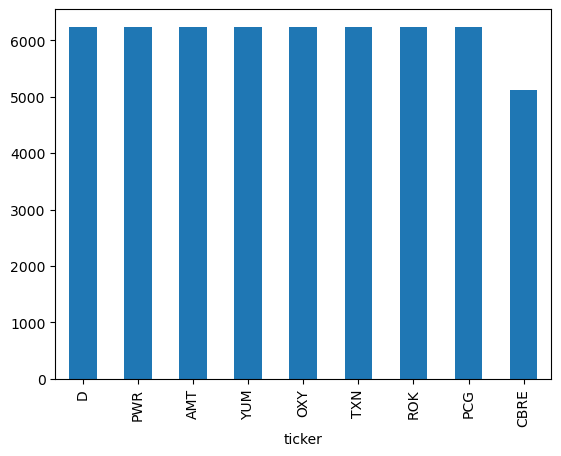

In [10]:
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

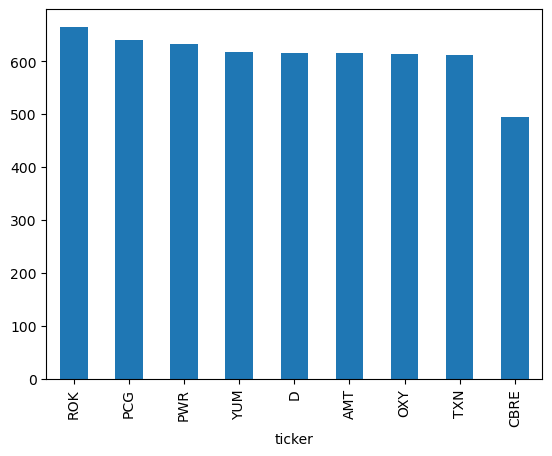

In [11]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

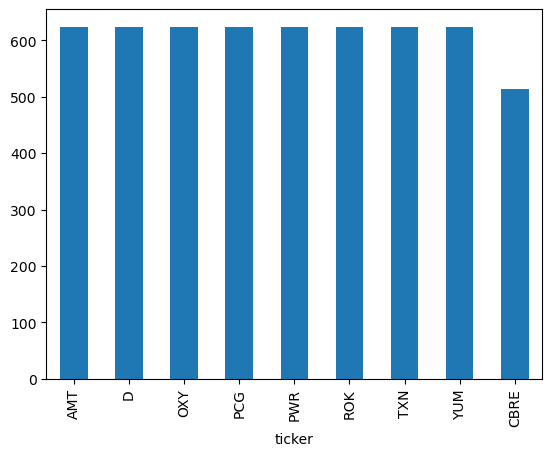

In [12]:
strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

/var/folders/h3/hl0mqnds7b1fzrh1jyt_rxth0000gn/T/ipykernel_16341/2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

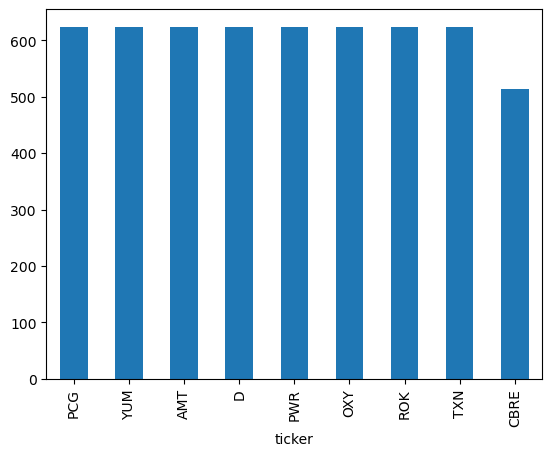

In [13]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')